________________________________________________________________________
Cumulative Incidence Functions (CIFs) in the presence of competing risks
________________________________________________________________________

In [8]:
%load_ext rpy2.ipython
# Load the rpy2 IPython extension into the notebook to use R with a magic command: %%R

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
%%R
# :::::::::
# R kernel
# :::::::::

# Install R packages
install.packages("readxl")
install.packages("writexl")
install.packages("cmprsk")

In [10]:
%%R
# :::::::::
# R kernel
# :::::::::

# Load necessary packages
library("readxl")
library("writexl")

# Import the CumIncidence function (Scrucca et al., 2007) from the file: 
# "CumIncidence.R" is available at http://www.stat.unipg.it/luca/misc/CumIncidence.R 
source("CumIncidence.R") 

# Import time-to-even data: columns with time and events are needed
cohort <- read_excel("kihd_time_to_event.xlsx")

# Create a vector of time points for calculating confidence intervals (CIs)
time_sorted <- c(0, sort(unique(cohort$time)))
# Estimate CIFs and corresponding CIs by passing the set of parameters:
# times, events, code for censoring, time points for CIs, confidence level for CIs
fit = CumIncidence(cohort$time, cohort$event, cencode = 0, t = time_sorted, level = 0.95)

# Post-process the results to save them in a file
#
# Define names for competing events that are encoded with numbers 1,...,l in the data:
# For example, 1 corresponds to 'CVD' and 2 corresponds to 'non-CVD', therefore:
comp_risks_names <- c('CVD', 'non-CVD')
# Get the number of competing risks
n_comp_risks <- length(comp_risks_names)

# Initialize a data frame to store CIFs and CIs at times from 'time_sorted'
all_cause_results <- data.frame(row.names = time_sorted)

# Get the results for each cause
for (i in seq(n_comp_risks))
{
  result_specific <- as.data.frame(fit$est[i,]) # CIF estimate
  result_specific <- cbind(result_specific, as.data.frame(fit$ci[1,,i])) # CI: lower boundary
  result_specific <- cbind(result_specific, as.data.frame(fit$ci[2,,i])) # CI: upper boundary
  
  # Edit column names
  colnames(result_specific) <- c(comp_risks_names[i], 
                        paste(comp_risks_names[i],'CI lower'), 
                        paste(comp_risks_names[i],'CI upper'))
  
  # Add the cause-specific results to the data frame
  all_cause_results <- cbind(all_cause_results, result_specific)
  
}

# Add the column with time points to the data
all_cause_results['time'] <- rownames(all_cause_results)

# Save data in the file 'CIF_and_CI.xlsx'
write_xlsx(all_cause_results, 'CIF_and_CI.xlsx')

_____________________________________________
Compare KM-estimates with cause-specific CIFs
_____________________________________________

In [6]:
# :::::::::::::
# Python kernel
# :::::::::::::

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns 

# Read time-to-event data from the file
time_to_event_data = pd.read_excel("kihd_time_to_event.xlsx")

# Read CIFs and CIs produced with the R-function
CIF = pd.read_excel("CIF_and_CI.xlsx")

# Add a column with time in years (it will be used for plots)
CIF['time, years'] = CIF['time']/365.25

In [7]:
# Estimate all-cause survival (incidence and CI) with the KM method: 
kmf = KaplanMeierFitter()
kmf.fit(time_to_event_data["time"], event_observed=time_to_event_data["event"])
all_cause_survival = 1 - kmf.survival_function_
all_cause_survival = all_cause_survival.join(1 - kmf.confidence_interval_)

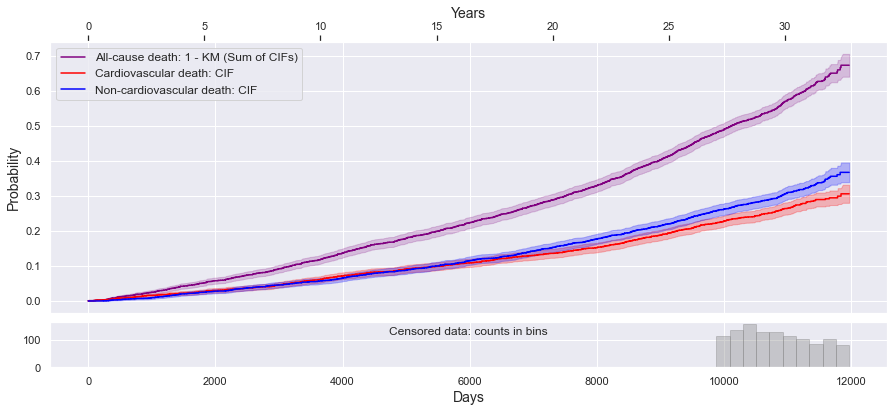

In [9]:
# ------------------------------------
# Produce a plot with incidence curves
# ------------------------------------

sns.set()
fig, ax = plt.subplots(figsize = (15,5)) 

# Draw cumulative incidence curves
ax.step(all_cause_survival.index, all_cause_survival.loc[:, 'KM_estimate'], color = 'purple', label = 'All-cause death: 1 - KM (Sum of CIFs)')
ax.step(CIF.loc[:, 'time'], CIF.loc[:, 'CVD'], color = 'red', label = 'Cardiovascular death: CIF')
ax.step(CIF.loc[:, 'time'], CIF.loc[:, 'non-CVD'], color = 'blue', label = 'Non-cardiovascular death: CIF')

# Draw CIs for corresponding cumulative incidence curves
ax.fill_between(CIF.loc[:, 'time'], CIF.loc[:, 'CVD CI lower'], 
                 CIF.loc[:, 'CVD CI upper'], alpha=.25, color = 'red')
ax.fill_between(CIF.loc[:, 'time'], CIF.loc[:, 'non-CVD CI lower'], 
                 CIF.loc[:, 'non-CVD CI upper'], alpha=.25, color = 'blue')
ax.fill_between(all_cause_survival.index, all_cause_survival.loc[:, 'KM_estimate_lower_0.95'], 
                 all_cause_survival.loc[:, 'KM_estimate_upper_0.95'], alpha=.20, color = 'purple')

ax.set_xlabel("Days", fontsize = 14)
ax.set_ylabel("Probability", fontsize = 14)

plt.legend(fontsize = 12)

def day2year(x):
    return x / 365.25

def year2day(x):
    return x * 365.25

# Add an axis with years
secax = ax.secondary_xaxis('top', functions=(day2year, year2day))
secax.set_xlabel('Years', fontsize = 14)


# Add a histogram for censored subjects
left, width = 0.125, 0.775
bottom, height = -0.025, 0.5
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom, width, 0.125]

ax_histx = fig.add_axes(rect_histx, sharex=ax)

ax_histx.hist(time_to_event_data.loc[time_to_event_data.loc[:, 'event'] == 0, 'time'], bins=10, color = 'gray', alpha = 0.35, edgecolor='gray')
ax_histx.set_title("Censored data: counts in bins", y = 0.6, x = 0.5)
ax_histx.set_xlabel("Days", fontsize = 14)

# Save in a file
# plt.savefig("KM vs CIF.png", bbox_inches='tight')

In [34]:
# Estimate cause-specific risks with the KM-method for predefined periods 

competing_risks = {1: 'CVD', 2: 'non-CVD'}
follow_ups_years = [1, 10, 15, 20, 30]
follow_ups = np.array(follow_ups_years)*365.25

cause_specific_survival_KM = pd.DataFrame(index = follow_ups_years)
kmf.fit(time_to_event_data["time"], event_observed=time_to_event_data["event"])
cause_specific_survival_KM.loc[:, 'all risks'] = kmf.survival_function_at_times(follow_ups).values

for cr in competing_risks.keys():
    kmf.fit(time_to_event_data["time"], event_observed=time_to_event_data["event"] == cr)

    cause_specific_survival_KM.loc[:, 'risk {}'.format(cr)] = kmf.survival_function_at_times(follow_ups).values
    

In [37]:
# Create a data frame with the results obtained with KM and CIF methods for different follow-up periods
graph_data = pd.DataFrame()

for follow_up in follow_ups_years:
    
    index_follow_up = np.argmin(np.abs(CIF['time, years'] - follow_up))
    
    probability = [cause_specific_survival_KM.loc[follow_up, 'all risks']]
    
    for cr in competing_risks.keys():
        probability += [1 - cause_specific_survival_KM.loc[follow_up, 'risk {}'.format(cr)]]
    
    probability += [1 - CIF.loc[index_follow_up, list(competing_risks.values())].sum()]
    
    for cr in competing_risks.keys():
        probability += [CIF.loc[index_follow_up, competing_risks[cr]]]
        
                   
    dict_follow_up = {
        'Follow-up period, years': [follow_up]*2*(len(competing_risks) + 1),
        'Method': ['KM'] * (len(competing_risks) + 1) + ['CIF'] * (len(competing_risks) + 1),
        'Event': (['Event free'] + list(competing_risks.values()))*2,
        'Probability': probability
    }
    
    graph_data = pd.concat([graph_data, pd.DataFrame(dict_follow_up)]).reset_index(drop = True)

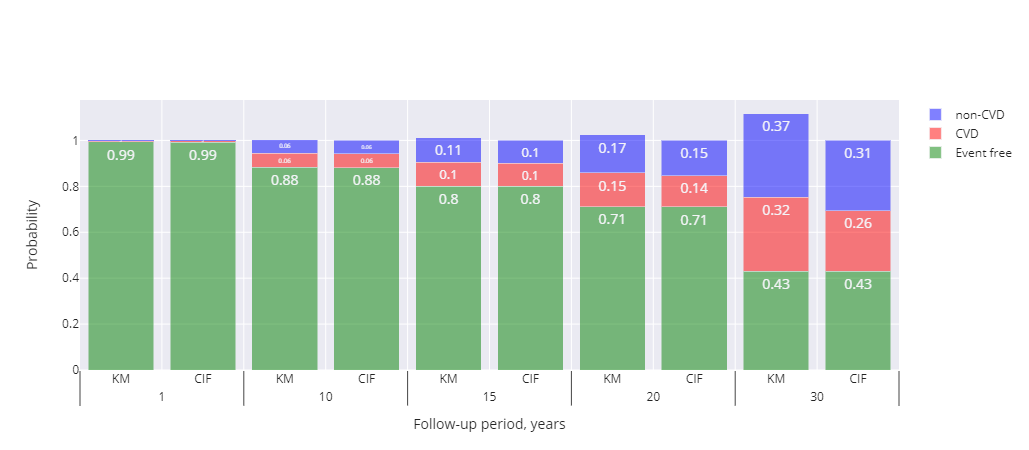

In [40]:
# Visualize estimated cause-specific risks: KM vs CIF

import plotly.graph_objects as go
import plotly.offline

fig = go.Figure()

fig.update_layout(
    template="seaborn",
    xaxis=dict(title_text="Follow-up period, years"),
    yaxis=dict(title_text="Probability"),
    barmode="stack",
)

colors = ["green", "red", "blue"]

for r, c in zip(grath_data.loc[:, 'Event'].unique(), colors):
    plot_df = grath_data[grath_data.loc[:, 'Event'] == r]
    fig.add_trace(
        go.Bar(x=[plot_df.loc[:, 'Follow-up period, years'], plot_df.loc[:, 'Method']], y=plot_df.loc[:, 'Probability'], 
               name=r, marker_color=c, opacity = 0.5, text = np.round(plot_df.loc[:, 'Probability'], 2)),
    )

fig.update_traces(textposition='inside', textfont_size=14)

# Save in a file:
#plotly.offline.plot(fig, filename='stacked bars KM vs CIF.html')